# Transfer learning lab

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, [Dublin City University](https://www.dcu.ie/)

[Insight Centre for Data Analytics](https://www.insight-centre.org/)


---

This lab will investigate the use of transfer learning for a simple binary classification problem. The dataset that we will work with is called "Alien vs Predator" and originally came from a [Kaggle competition](https://www.kaggle.com/pmigdal/alien-vs-predator-images). The task is to classify images as containing either the Alien creature from the Ridley Scott movie, or the Predator creature from the 1987 action classic Predator starring Arnold Schwarzenegger.

![AVP](https://crowdcast-prod.imgix.net/-Kab5fihhH1Q3R92MsOJ/event-cover-4763?w=800)


The dataset contains around 700 training examples and 200 validation examples, which are evenly balanced between the classes. However, 700 examples is quite a small dataset when comes to deep learning, and training a neural network from scratch (from a random initialization) would **overfit**.

This notebook will look at simple transfer learning techniques:
- Using a pretrained network **"off-the-shelf"** as a feature extractor. 
- **Fine tuning** a pretrained network for the new task.



## Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

## Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and then select *GPU* under hardware accelerator.

Change the line below to ``device = 'cpu'`` to run on the CPU instead.

In [ ]:
device = 'cuda'

## Imports


Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset download

Here we will use the "Alien vs Predator" dataset, which was originally taken from a [Kaggle competition](https://www.kaggle.com/pmigdal/alien-vs-predator-images). You can download it using this [Google Drive link](https://drive.google.com/file/d/15VkfIhAn7Yvz0UsxwDhjYkzie0COWLtR/view?usp=sharing). Here I use a utility function from PyTorch for downloading from Google Drive.

**Note** if the command below doesn't work, try replacing it with:
```
! wget https://www.eeng.dcu.ie/~mcguinne/data/ee514/avp.tar
! mv avp.tar data
```

In [ ]:
download_file_from_google_drive('15VkfIhAn7Yvz0UsxwDhjYkzie0COWLtR', 'data', 'avp.tar')

7997440it [00:00, 80175378.26it/s]


Extract the data and remove the tar file

In [ ]:
!cd data && tar xf avp.tar
!rm data/avp.tar
!ls data/avp

train  valid


## Create the dataset

We will use the `ImageFolder` class as the dataset. This works whenever we have a folder of subfolders, each which represents a class.

We also specify here a set of transforms to be applied to the data. The train transform is stochastic, which will help prevent overfitting when we do fine tuning. The validation transform is deterministic, which ensures we will have consistent results on the same data.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),                                 
    transforms.RandomCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.Resize(224),    
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

train_set = ImageFolder('data/avp/train', transform=train_transform)

# Create an analagous ImageFolder for the validation set
valid_set = ImageFolder('data/avp/valid', transform=valid_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Create a loader for the validation set, but disable shuffling of the validation data
# (it is unnecessary to shuffle validation data)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=True)

In [ ]:
print(f'train samples: {len(train_set)}  validation samples: {len(valid_set)}')

train samples: 694  validation samples: 200


Let's take a look at some examples from the training set

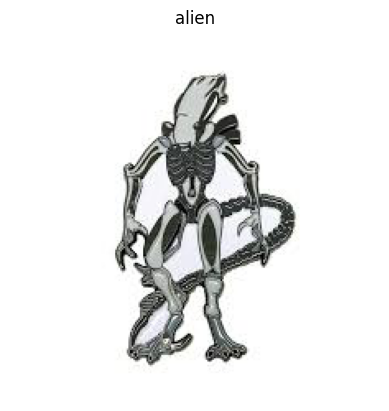

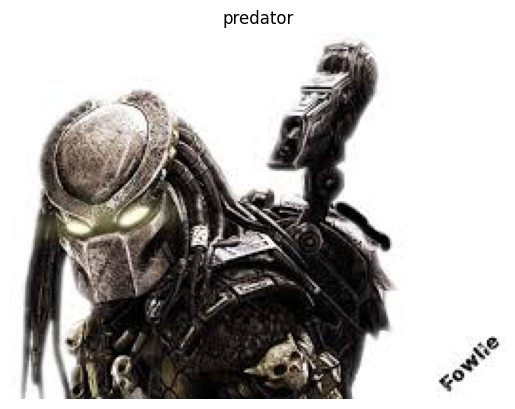

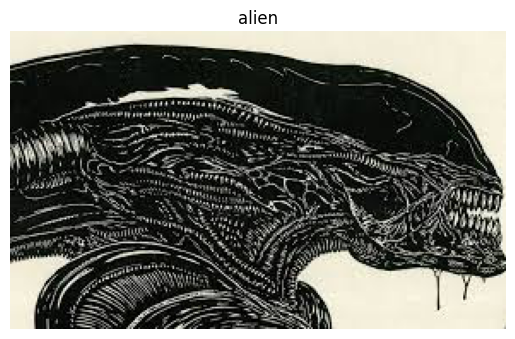

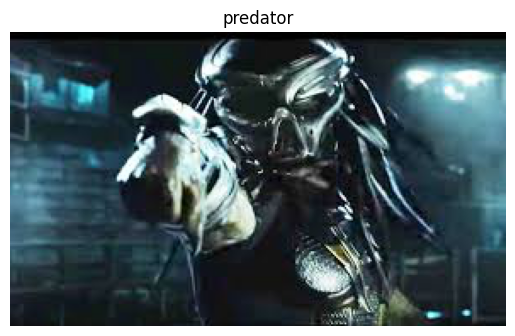

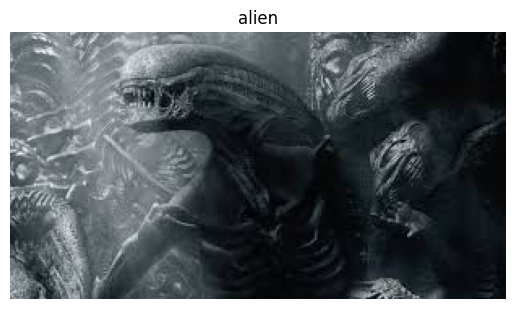

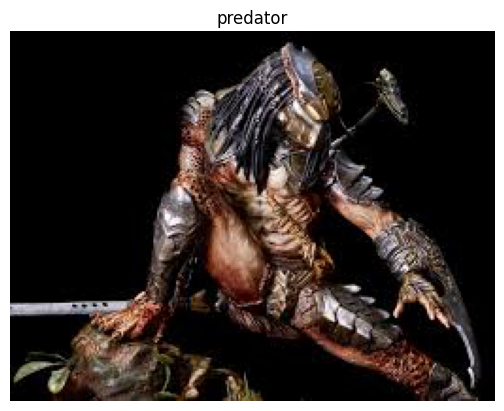

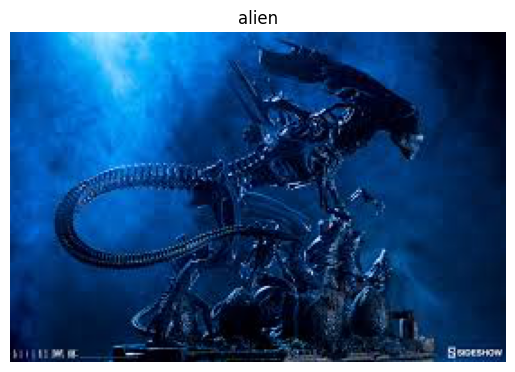

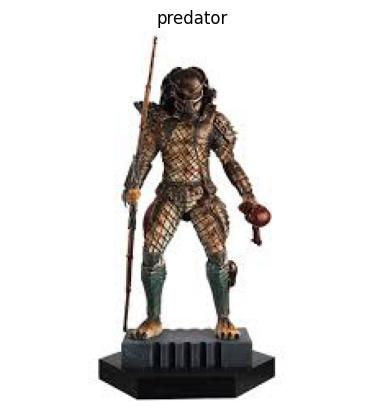

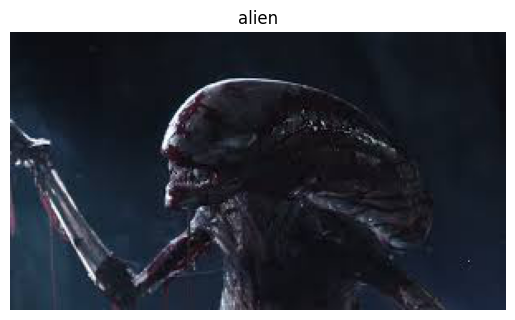

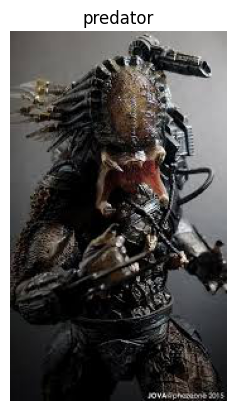

In [ ]:
visual_train_set = ImageFolder('data/avp/train')
for i in range(5):
    plt.figure()
    plt.imshow(visual_train_set[i][0])
    plt.title(visual_train_set.classes[visual_train_set[i][1]])
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(visual_train_set[i+400][0])
    plt.title(visual_train_set.classes[visual_train_set[i+400][1]])
    plt.axis('off')
    plt.show()

## Load a pre-trained ResNet model

Let's use the ResNet-50 model described by Kaiming He in his seminal paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

In [ ]:
model = models.resnet50(pretrained=True)
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Off-the-shelf transfer learning

Let's start with "off-the-shelf" transfer learning. Here we will just use the pretrained model as a feature extractor and then train a linear classifier on the features.

The first thing we need to do is to remove the last fully connected layer. An empty `nn.Sequential` layer can be used as an Identity mapping.

In [ ]:
model.fc = nn.Sequential() 

Note that you can also use [forward hooks](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.register_forward_hook) for this, but here it's simpler just to drop the final layer.

The next thing to do is put the model in `eval` mode and extract the features for the training set.

In [ ]:
# model

In [ ]:
def extract_features(loader):
    
    # put the model in eval mode
    model.eval()

    features, labels = [], []
    
    with torch.no_grad():
        for batch, targets in loader:
            batch = batch.to(device)

            # extract the features using the model
            batch_features = model(batch)

            features.append(batch_features.data.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

train_features, train_labels = extract_features(train_loader)
valid_features, valid_labels = extract_features(valid_loader)

print(f'train features are {train_features.shape}')
print(f'valid features are {valid_features.shape}')

train features are (694, 2048)
valid features are (200, 2048)


Now, train a classical machine learning model on the representations. Here we'll try a **logistic regression** (or technically, the multiclass counterpart, softmax regression, but [scikit-learn](https://scikit-learn.org/) doesn't distinguish between these).

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression(C=1, solver='liblinear')

# Fit the logistic regression classifier on the training features
classifier.fit(train_features,train_labels)

LogisticRegression(C=1, solver='liblinear')

In [ ]:
# make predictions using the logistic regression classifier on the validation features
y_hat = classifier.predict(valid_features)


In [ ]:
accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.940


You should get 94.5% accuracy off the shelf: not bad! The validation set is balanced, so this is an excellent start.

In [ ]:
print(metrics.classification_report(valid_labels, y_hat, target_names=train_set.classes))

              precision    recall  f1-score   support

       alien       0.94      0.94      0.94       100
    predator       0.94      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



Let's try something nonlinear like a **support vector machine** with a radial basis function.

In [ ]:
from sklearn.svm import SVC

In [ ]:
classifier = SVC()
classifier.fit(train_features, train_labels)

SVC()

In [ ]:
# make predictions
y_hat = classifier.predict(valid_features)

In [ ]:
accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.925


Looks like accuracy is about the same as the linear classifier. This suggests that the classes are approximately linearly separable.

## Fine tuning

Let's try replace the last layer of the ResNet and fine tune it on the AVP dataset for a few epochs

In [ ]:
torch.manual_seed(31337)
np.random.seed(31337)

In [ ]:
model = models.resnet50(pretrained=True)
# Replace fc with a linear layer that maps features of dimension 2048 to the number of classes (2)
model.fc = nn.Linear(2048,2)
model.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
!mkdir -p checkpoints

In [ ]:
def train_for_epoch(optimizer):

    # put the model in training mode
    model.train()

    train_losses = []

    for batch, target in train_loader:

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predictions.argmax(dim=1).cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    valid_accuracy = np.mean(y_true == y_pred)

    # calculate the mean validation loss
    valid_loss = np.mean(valid_losses)

    return valid_loss, valid_accuracy


# training loop
def train(epochs, optimizer, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, valid_acc = validate()

        # print status
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  '
              f'acc: {valid_acc:0.04f}')
        
        # save checkpoint
        torch.save(model, f'checkpoints/avp_{epoch:03d}.pkl')

Train the final layer for a few epochs to get it to a good place (remember, it starts off with random weights but the rest of the network has pre-trained weights from ImageNet)

In [ ]:
final_layer_optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
train(2, final_layer_optimizer)

[01] train loss: 0.4808  valid loss: 0.3203  acc: 0.8950
[02] train loss: 0.2295  valid loss: 0.2708  acc: 0.9250


Now fine tune whole network with a lower learning rate

In [ ]:
full_network_optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train the model using the full network optimizer above for 20 epochs starting at epoch 3

train(20, full_network_optimizer, first_epoch=3)
    

[03] train loss: 0.1471  valid loss: 0.1502  acc: 0.9050
[04] train loss: 0.1221  valid loss: 0.2261  acc: 0.8950
[05] train loss: 0.0974  valid loss: 0.1483  acc: 0.9250
[06] train loss: 0.0589  valid loss: 0.2051  acc: 0.9500
[07] train loss: 0.0497  valid loss: 0.2225  acc: 0.9450
[08] train loss: 0.0386  valid loss: 0.1977  acc: 0.9450
[09] train loss: 0.0471  valid loss: 0.1556  acc: 0.9450
[10] train loss: 0.0276  valid loss: 0.1159  acc: 0.9400
[11] train loss: 0.0317  valid loss: 0.1056  acc: 0.9450
[12] train loss: 0.0304  valid loss: 0.1187  acc: 0.9500
[13] train loss: 0.0316  valid loss: 0.1072  acc: 0.9500
[14] train loss: 0.0261  valid loss: 0.1091  acc: 0.9500
[15] train loss: 0.0225  valid loss: 0.1931  acc: 0.9600
[16] train loss: 0.0134  valid loss: 0.0930  acc: 0.9600
[17] train loss: 0.0214  valid loss: 0.1872  acc: 0.9450
[18] train loss: 0.0203  valid loss: 0.1426  acc: 0.9600
[19] train loss: 0.0139  valid loss: 0.0998  acc: 0.9500
[20] train loss: 0.0167  valid 

Drop the learning rate to $10^{-4}$ and tune a little more...

In [ ]:
for param_group in full_network_optimizer.param_groups:
    param_group['lr'] = 0.0001

train(5, full_network_optimizer, 23)

[23] train loss: 0.0124  valid loss: 0.1036  acc: 0.9550
[24] train loss: 0.0141  valid loss: 0.1114  acc: 0.9600
[25] train loss: 0.0125  valid loss: 0.1384  acc: 0.9600
[26] train loss: 0.0180  valid loss: 0.1309  acc: 0.9600
[27] train loss: 0.0116  valid loss: 0.1013  acc: 0.9600


The best model should have 96.5% accuracy, so we've gained about 2% accuracy over the off the shelf method by fine tuning.

In [ ]:
model = torch.load('checkpoints/avp_023.pkl')

Clean up the checkpoints

In [ ]:
!rm -rf checkpoints/*

## Training from scratch

What would happen if, instead of fine tuning a pre-trained network, we decided to train one from scratch? Let's see!

In [ ]:
# create a resnet50 model as before but do NOT load pre-trained weights
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048,2)
model.to(device);

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Create an SGD optimizer with learning rate 0.01 and momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Now train using the above optimizer for 20 epochs

train(20, full_network_optimizer, first_epoch=1)

[01] train loss: 0.7491  valid loss: 0.6845  acc: 0.5000
[02] train loss: 0.7508  valid loss: 0.7242  acc: 0.5000
[03] train loss: 0.7556  valid loss: 0.7221  acc: 0.5000
[04] train loss: 0.7528  valid loss: 0.7344  acc: 0.4450
[05] train loss: 0.7608  valid loss: 0.7532  acc: 0.4300
[06] train loss: 0.7465  valid loss: 0.7749  acc: 0.4500
[07] train loss: 0.7523  valid loss: 0.7703  acc: 0.4300
[08] train loss: 0.7523  valid loss: 0.7640  acc: 0.4450
[09] train loss: 0.7485  valid loss: 0.8285  acc: 0.4800
[10] train loss: 0.7465  valid loss: 0.8001  acc: 0.4500
[11] train loss: 0.7514  valid loss: 0.7647  acc: 0.4400
[12] train loss: 0.7511  valid loss: 0.7539  acc: 0.4450
[13] train loss: 0.7493  valid loss: 0.8218  acc: 0.4550
[14] train loss: 0.7526  valid loss: 0.8101  acc: 0.4500
[15] train loss: 0.7517  valid loss: 0.8483  acc: 0.4600
[16] train loss: 0.7485  valid loss: 0.7956  acc: 0.4600
[17] train loss: 0.7538  valid loss: 0.7950  acc: 0.4600
[18] train loss: 0.7435  valid 

Clearly the transfer learning approach works much better!